# Topic modeling

Classer des textes par thématique.

L'idée est que chaque texte d'un corpus peut appartenir à une ou plusieurs thématiques

## LDA

[Une explication simple ici](https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-latent-dirichlet-allocation-437c81220158)

La méthode LDA est la plus utilisée. Elle devient presque synonime de topic modeling

LDA est l'acronyme de 'Latent Dirichlet Allocation'

L'idée derrière LDA est que chaque document puisse être décrit avec une distribution de "sujets" (topics) et que chaque sujet est representé par une distribution de mots.


On commence donc par relier les documents au dictionnaire de tous les mots du corpus:

![](https://miro.medium.com/max/700/1*QQTk2TGyzhakGh0lZ9P03w.jpeg)


Ensuite il faudra trouver les sujets "cachés" (latent). On le fera en mettant ensemble un certain nombre de mots:

![](https://miro.medium.com/max/700/1*2uj6t3gNv76SpHrWf5-z-A.jpeg)

La distribution de Dirichlet est une règle probabilistique qui sert pour calculer la probabilité de distribution dans un espace à `n` dimensions.

### Nombre de sujets

Évidemment c'est à nous de déterminer combien de sujet on veut.

## Topic modeling sur les épigrammes en anglais de l'AP


Nous allons d'abord importer tous les textes en anglais depuis l'api et mettre:

1. Les textes dans une liste qui s'apelera `english_texts`
2. Les titres des textes dans une liste qui s'appelera `text_titles`

In [1]:
import json 
import requests
entities = requests.get('https://anthologia.ecrituresnumeriques.ca/api/v1/entities/').json() 
english_texts=[]
text_titles=[] 
for entity in entities:
    for version in entity['versions']:
        if version['id_language'] is 3: 
            if 'Iliad' not in entity['title']: # l'iliade fait bcp de bruit!
                
                text = version['text_translated']
                english_texts.append(text)
                text_titles.append(entity['title'])

D'abord on doit télécharger et décomprimer http://mallet.cs.umass.edu/download.php. C'est une librairie pour faire du LDA. Cf. ici https://melaniewalsh.github.io/Intro-Cultural-Analytics/Text-Analysis/Topic-Modeling-Overview.html

Puis on installe un wrapper

In [2]:
import little_mallet_wrapper # mallet
import seaborn # dataviz library

In [3]:
# on déclare le chemin de mallet
path_to_mallet = '/home/marcello/Downloads/mallet-2.0.8/bin/mallet'

Maintenant nous allons utiliser une fonction de mallet: `little_mallet_wrapper.process_string()` et l'appliquer à tous les textes anglais. C'est une fonction qui va normaliser les textes:

- mettre en minuscule
- enlever les stopwords
- enlever la punctuation
- enlever les chifres

On va mettre les textes normalisés dans la liste `training_data`

In [38]:
training_data = []
stfile='/home/marcello/Downloads/mallet-2.0.8/stoplists/en.txt'
with open(stfile, 'r') as file:
    stopwords=file.read().split('\n')
#stopwords=['one', 'would', 'say', 'give', 'came', 'much', 'thou', 'thy', 'thee', 'shall', 'even']
for text in english_texts:
    #processed_text = little_mallet_wrapper.process_string(text, numbers='remove', remove_stop_words=True)
    processed_text = little_mallet_wrapper.process_string(text, numbers='remove', stop_words=stopwords)
    training_data.append(processed_text)

La fonction `little_mallet_wrapper.print_dataset_stats()` donne des statiststiques sur les données:

In [39]:
little_mallet_wrapper.print_dataset_stats(training_data)

Number of Documents: 1283
Mean Number of Words per Document: 20.9
Vocabulary Size: 7525


In [61]:
num_topics = 5 # on décide combien de topics nous voulons identifier
training_data = training_data # les données à processer (on les a déjà mises dans la liste training_data)

In [62]:
from pathlib import Path # librairie pour se simplifier la vie en manipulant les chemins
#On va mettre les outputs dans le dossier topics. C'est ici que les données pour l'entrainement seront stockées
output_directory_path = 'topics'

#No need to change anything below here
Path(f"{output_directory_path}").mkdir(parents=True, exist_ok=True)

path_to_training_data           = f"{output_directory_path}/training.txt"
path_to_formatted_training_data = f"{output_directory_path}/mallet.training"
path_to_model                   = f"{output_directory_path}/mallet.model.{str(num_topics)}"
path_to_topic_keys              = f"{output_directory_path}/mallet.topic_keys.{str(num_topics)}"
path_to_topic_distributions     = f"{output_directory_path}/mallet.topic_distributions.{str(num_topics)}"

## On importe les données

Avec la fonction `little_mallet_wrapper.import_data()`

In [63]:
little_mallet_wrapper.import_data(path_to_mallet,
                path_to_training_data,
                path_to_formatted_training_data,
                training_data)

Importing data...
Complete


## Entrainement

Avec la fonction `little_mallet_wrapper.train_topic_model()`

In [64]:
little_mallet_wrapper.train_topic_model(path_to_mallet,
                      path_to_formatted_training_data,
                      path_to_model,
                      path_to_topic_keys,
                      path_to_topic_distributions,
                      num_topics)

Training topic model...
Complete


## Visualiser!

La fonction `little_mallet_wrapper.load_topic_keys()` va lire et analyser l'output de l'entrainement.

In [65]:
topics = little_mallet_wrapper.load_topic_keys(path_to_topic_keys)

for topic_number, topic in enumerate(topics):
    print(f"✨Topic {topic_number}✨\n\n{topic}\n")

✨Topic 0✨

['god', 'art', 'made', 'men', 'life', 'good', 'son', 'beauty', 'soul', 'holy', 'man', 'time', 'christ', 'wisdom', 'light', 'house', 'heaven', 'hath', 'gave', 'things']

✨Topic 1✨

['death', 'hades', 'tomb', 'dead', 'mother', 'father', 'life', 'left', 'age', 'child', 'hand', 'children', 'fate', 'hands', 'young', 'woman', 'alas', 'house', 'wife', 'stone']

✨Topic 2✨

['love', 'sweet', 'wine', 'night', 'eyes', 'longer', 'fire', 'hair', 'muses', 'cypris', 'heart', 'sleep', 'long', 'lovely', 'bacchus', 'graces', 'drink', 'day', 'song', 'dost']

✨Topic 3✨

['sea', 'land', 'man', 'ship', 'water', 'buried', 'bones', 'rest', 'long', 'set', 'end', 'waves', 'fell', 'empty', 'head', 'feet', 'shore', 'deep', 'lie', 'living']

✨Topic 4✨

['tomb', 'earth', 'great', 'men', 'lies', 'body', 'country', 'son', 'lie', 'city', 'man', 'dead', 'died', 'muses', 'arms', 'stranger', 'monument', 'hail', 'zeus', 'holds']



## Distibution des topics

la fonction `little_mallet_wrapper.load_topic_distributions()` crée une liste avec la distribution des topics (en probabilité) par text.

In [66]:
topic_distributions = little_mallet_wrapper.load_topic_distributions(path_to_topic_distributions)

In [67]:
 topic_distributions[1] #distribution pour le texte 2

[0.15294117647058825,
 0.06274509803921569,
 0.6705882352941176,
 0.0392156862745098,
 0.07450980392156863]

On peut coupler les textes avec leurs titres pour avoir une meilleure idée:

In [68]:
text_to_check = "Greek Anthology 7.22"

text_number = text_titles.index(text_to_check)

print(f"Topic Distributions for {text_titles[text_number]}\n")
for topic_number, (topic, topic_distribution) in enumerate(zip(topics, topic_distributions[text_number])):
    print(f"✨Topic {topic_number} {topic[:6]} ✨\nProbability: {round(topic_distribution, 3)}\n")

Topic Distributions for Greek Anthology 7.22

✨Topic 0 ['god', 'art', 'made', 'men', 'life', 'good'] ✨
Probability: 0.147

✨Topic 1 ['death', 'hades', 'tomb', 'dead', 'mother', 'father'] ✨
Probability: 0.088

✨Topic 2 ['love', 'sweet', 'wine', 'night', 'eyes', 'longer'] ✨
Probability: 0.559

✨Topic 3 ['sea', 'land', 'man', 'ship', 'water', 'buried'] ✨
Probability: 0.029

✨Topic 4 ['tomb', 'earth', 'great', 'men', 'lies', 'body'] ✨
Probability: 0.176



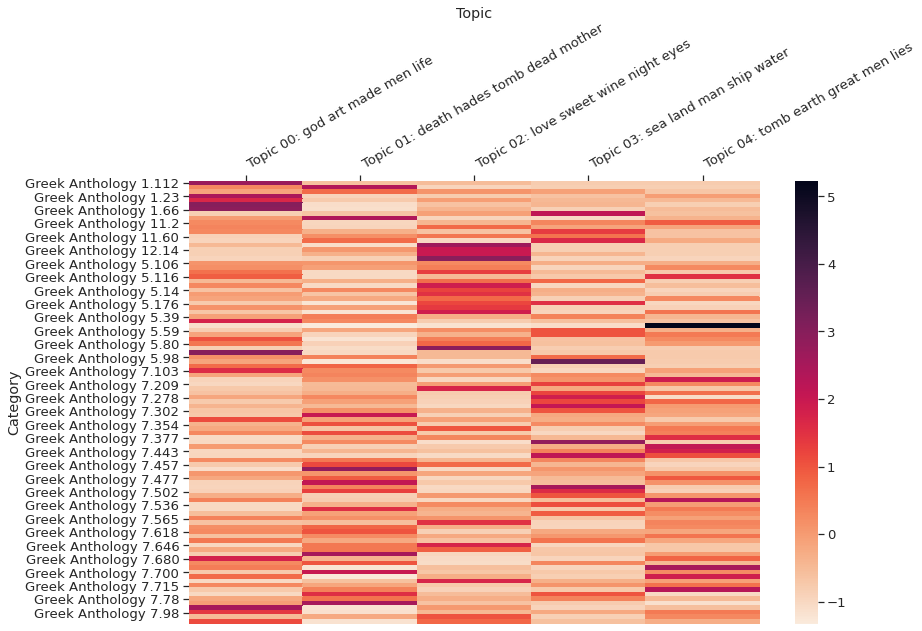

In [69]:
import random
target_labels = random.sample(text_titles, 100)
little_mallet_wrapper.plot_categories_by_topics_heatmap(text_titles,
                                      topic_distributions,
                                      topics, 
                                      output_directory_path + '/categories_by_topics.pdf',
                                      target_labels=target_labels,
                                      dim= (13, 9)
                                     )

In [70]:
training_data_text_titles = dict(zip(training_data, text_titles))
training_data_original_text = dict(zip(training_data, english_texts))
def display_top_titles_per_topic(topic_number=0, number_of_documents=5):
    
    print(f"✨Topic {topic_number}✨\n\n{topics[topic_number]}\n")

    for probability, document in little_mallet_wrapper.get_top_docs(training_data, topic_distributions, topic_number, n=number_of_documents):
        print(round(probability, 4), training_data_text_titles[document] + "\n")
    return
display_top_titles_per_topic(topic_number=1, number_of_documents=50)

✨Topic 1✨

['death', 'hades', 'tomb', 'dead', 'mother', 'father', 'life', 'left', 'age', 'child', 'hand', 'children', 'fate', 'hands', 'young', 'woman', 'alas', 'house', 'wife', 'stone']

0.7826 Greek Anthology 7.729

0.7778 Greek Anthology 7.583

0.7727 Greek Anthology 7.184

0.7667 Greek Anthology 7.387

0.7576 Greek Anthology 7.186

0.75 Greek Anthology 7.576

0.7333 Greek Anthology 7.167

0.7162 Greek Anthology 7.334

0.7105 Greek Anthology 7.712

0.7097 Greek Anthology 7.610

0.7 Greek Anthology 7.481

0.6944 Greek Anthology 7.568

0.6857 Greek Anthology 7.466

0.6818 Greek Anthology 7.181

0.6818 Greek Anthology 7.48

0.6818 Greek Anthology 7.48

0.678 Greek Anthology 7.468

0.6774 Greek Anthology 7.165

0.6667 Greek Anthology 7.555

0.6667 Greek Anthology 7.483

0.6667 Greek Anthology 7.611

0.6585 Greek Anthology 7.464

0.6571 Greek Anthology 7.730

0.6562 Greek Anthology 7.604

0.65 Greek Anthology 7.188

0.65 Greek Anthology 7.224

0.6486 Greek Anthology 7.163

0.6471 Greek A